## I. Import Libraries and Preferences

### Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

import os
import pickle  
import joblib

## II. Exploratory Data Analysis

In [7]:
# Dataset URL used in this notebook is from the following link
# https://datahub.io/core/gold-prices

DATASET_URL = './datasets/monthly.csv'
data = pd.read_csv(DATASET_URL)
data.head()

,Date,Price
0,1833-01,18.93
1,1833-02,18.93
2,1833-03,18.93
3,1833-04,18.93
4,1833-05,18.93


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2301 non-null   object 
 1   Price   2301 non-null   float64
dtypes: float64(1), object(1)
memory usage: 36.1+ KB


In [9]:
data.describe()

,Price
count,2301.00000
mean,208.28100
std,422.63896
min,17.06000
25%,18.93000
50%,20.66000
75%,160.45000
max,2570.55000


# Data Cleaning

#### Data Preprocess

In [10]:
# Load the data
data = pd.read_csv(DATASET_URL)

# Ensure the Date column is treated as a string
data['Date'] = data['Date'].astype(str)  # Convert Date to string type

# Replace '-' with '.' and convert to float
data['Date'] = data['Date'].str.replace('-', '.').astype(float)

# Save the preprocessed data
directory = 'datasets'

if not os.path.exists(directory):
    os.makedirs(directory)

filepath = os.path.join(directory, 'preprocess.csv')

data.to_csv(filepath, index=False)

data.head()


,Date,Price
0,1833.01,18.93
1,1833.02,18.93
2,1833.03,18.93
3,1833.04,18.93
4,1833.05,18.93


# Visualization

#### Date vs Average Price of Gold per Troy Ounce in USD

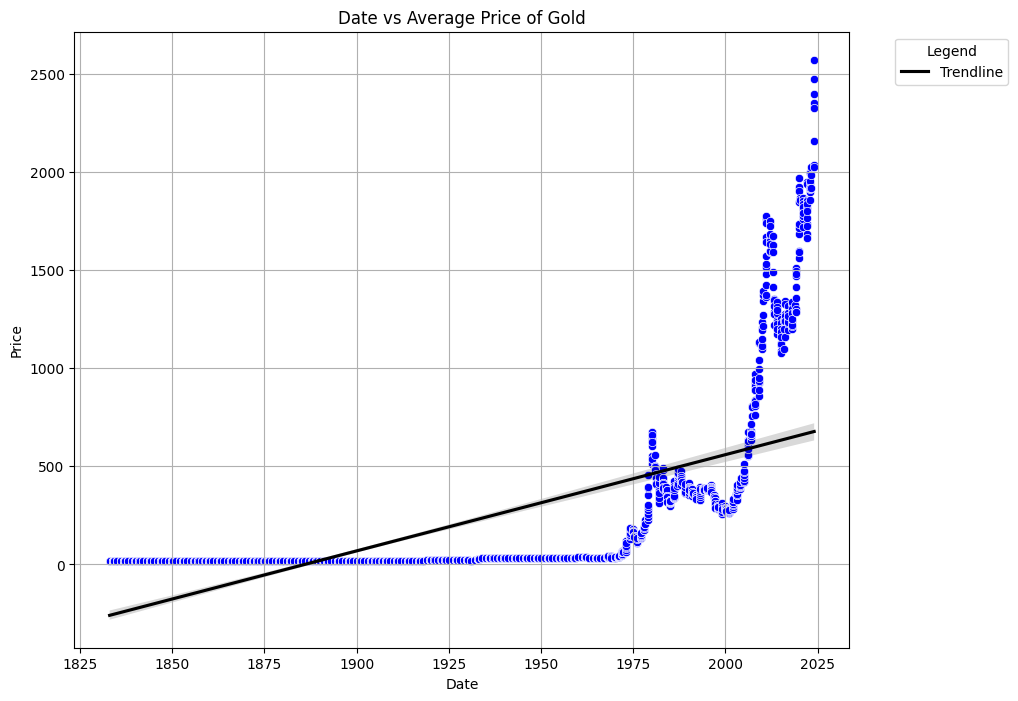

In [11]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=data, x='Date', y='Price', color='blue')
plt.title('Date vs Average Price of Gold')
plt.xlabel('Date (YYYY.MM)')
plt.ylabel('Average Price')

# Add gridlines
plt.grid(True)

# Add a trend line
sns.regplot(data=data, x='Date', y='Price', scatter=False, ax=scatter.axes, color='black', label='Trendline')

# Customize legend
handles, labels = scatter.get_legend_handles_labels()
labels.append('Trendline')
plt.legend(handles=handles, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# Model Training

### XGBoost

In [12]:
PREPROCESS_URL = './datasets/preprocess.csv'

# Load the dataset
data = pd.read_csv(PREPROCESS_URL)

# Clean column names
data.rename(columns={'Date    ': 'Date'}, inplace=True)
data.columns = data.columns.str.strip()

# Split the dataset into features and target
X = data[['Date']]  # Use 'Date' as the feature
y = data['Price']   # Use 'Price' as the target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Save the model as a .pkl file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)


Root Mean Squared Error: 27.708480598401
R-squared: 0.9949594483247642


#### Polynomial Regression

In [13]:
# Load the dataset
data = pd.read_csv(PREPROCESS_URL)

# Clean column names
data.rename(columns={'Date    ': 'Date'}, inplace=True)
data.columns = data.columns.str.strip()

# Split the dataset into features and target
X = data[['Date']]  # Use 'Date' as the feature
y = data['Price']   # Use 'Price' as the target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a polynomial regression model (try degree=2, 3, etc. for best performance)
degree = 3  # Increase this value if needed
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

# Save the model to a file
model_filename = "poly.pkl"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

# Display results
print(f'Polynomial Regression Mean Absolute Error (Test): {test_mae:.2f}')
print(f'Polynomial Regression R^2 Score (Test): {test_r2:.2f}')
print(f"Model Accuracy (R² Score on Test Set): {test_r2:.2f} or {test_r2 * 100:.2f}%")

Polynomial Regression Mean Absolute Error (Test): 94.00
Polynomial Regression R^2 Score (Test): 0.87
Model Accuracy (R² Score on Test Set): 0.87 or 86.90%


#### LSTM

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv("./datasets/preprocess.csv")

# Correctly parse 'Date' format
data['Date'] = pd.to_datetime(data['Date'].astype(str), format='%Y.%m')
data.set_index('Date', inplace=True)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Price']])

# Create sequences of look_back length
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12  # Use 12 months as look back
X, Y = create_dataset(scaled_data, look_back)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=20)

# Save the model
model.save("lstm_model.h5")

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
train_r2 = r2_score(y_train[0], train_predict[:, 0])
test_r2 = r2_score(y_test[0], test_predict[:, 0])

# Display results
print(f'LSTM Model Root Mean Squared Error (Train): {train_rmse:.2f}')
print(f'LSTM Model Root Mean Squared Error (Test): {test_rmse:.2f}')
print(f'LSTM Model R^2 Score (Train): {train_r2:.2f}')
print(f'LSTM Model R^2 Score (Test): {test_r2:.2f}')

d:\Projects\gold-prices\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1831/1831 - loss: 2.7633e-040s651e-0431 - loss: 4.9529e-05   2/1831  ━━━━━━━━━━━━━━━━━━━━ 40s 27s 22ms/step - loss: 1.4561e-04 15ms/step - loss: 1.6132e-0 ━━━━━━━━━━━━━━━━━━━━ 7 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.4225e-04  ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.4855e-  41/1831━━━━━━━━━━━━━━━━━━━━  6s━━━━━━━━━━━━━━━━━━━━ 4ms/step - loss: 6.4965e-04 6s 4ms/step - loss: 6.5044e-0 ━━━━━━━━━━━━━━━━━━━━ 3ms/step - loss: 7.1515e-04  61/1831 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.2103e-0 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.8429e-0 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.8609e-0 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.9638e-0 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.9612e-0 ━━━━━━━━━━━━━━━━━━━5s  3ms/step - loss: 7.8410e-04━━━━━━━━━━━━━━━━━━━━ 5 118/1831 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.8195e-0 ━━━━━━━━━━━━━━━━━━━━ 3ms/step - loss: 7.5807e-04 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.5668e-0 ━━━━━━━━━━━━━━━━━━━ 158/18315s  3ms/step - loss: 7.

58/58━━━━━31/58━━━━━━━━━━━ 12s 213ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s ━━━━━━━━━━ ━━━━━━━━━━━━━━━━━━━━0s  2ms/st32/58  2ms/step━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
15/1515━━━━━━━━━━━━━━━━━━━  17ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Model Root Mean Squared Error (Train): 34.88
LSTM Model Root Mean Squared Error (Test): 138.18
LSTM Model R^2 Score (Train): 0.84
LSTM Model R^2 Score (Test): 0.94


#### Random Forest 

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv("./datasets/preprocess.csv")

# Correctly parse 'Date' format
data['Date'] = pd.to_datetime(data['Date'].astype(str), format='%Y.%m')
data.set_index('Date', inplace=True)

# Prepare the data
data['Date'] = data.index.year + (data.index.month - 1) / 12  # Convert dates to a continuous variable
X = data[['Date']]  # Feature: Date
y = data['Price']  # Target: Price

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Save the model
joblib.dump(model, 'rf_model.joblib')
print("Model saved as 'rf_model.joblib'")

Root Mean Squared Error (RMSE): 20.509990587568698
R-squared (R2): 0.9972382550408009
Model saved as 'rf_model.joblib'
